Modules

In [35]:
from ete3 import Tree
import itertools
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import statsmodels.api as sm
pd.options.mode.chained_assignment = None
from scipy import stats

Functions

In [16]:
def identity_line(ax=None, ls='--', *args, **kwargs):
    # see: https://stackoverflow.com/q/22104256/3986320
    ax = ax or plt.gca()
    identity, = ax.plot([], [], ls=ls, *args, **kwargs)
    def callback(axes):
        low_x, high_x = ax.get_xlim()
        low_y, high_y = ax.get_ylim()
        low = min(low_x, low_y)
        high = max(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(ax)
    ax.callbacks.connect('xlim_changed', callback)
    ax.callbacks.connect('ylim_changed', callback)
    return ax

Read sample names

In [17]:
indir = "../../sex_chromosome_coverage"
with open("{}/Samples".format(indir), "r") as sf:
    samples = [line.strip() for line in sf]

Read sexual chromosomes strings

In [18]:
sp2chrom = {}
with open("../data/Species_to_chromosomes.txt", "r") as fh:
    for line in fh:
        sp, chrX, chrY = line.split()
        sp2chrom[sp] = [chrX, chrY]

Read depth across genomic windows 

In [29]:
depths = pd.DataFrame()
for s in samples:
    dp_df = pd.read_csv("{}/depth/{}.regions.bed.gz".format(indir, s), sep="\t", header=None)
    dp_df.columns = ["chrom","start","end","dp"]
    sp = s.split(".")[0]
    dp_df["chrom"] = ["A" if c not in sp2chrom[sp] else "X" if sp2chrom[sp][0]==c else "Y" for c in dp_df.chrom]
    dp_df["indiv"] = s
    depths = pd.concat([depths, dp_df], axis=0)
    
depths["l"] = depths.end - depths.start
depths = depths[depths.l>500e3].reset_index(drop=True)

Normalize data and get sex of each individual 

In [30]:
# Norm
autosome_mean = depths[depths.chrom=="A"].groupby("indiv")["dp"].mean().to_dict()
depths["norm_dp"] = [r.dp/autosome_mean[r.indiv] for i,r in depths.iterrows()]
depths_x = depths[(depths.chrom=="X")]

# Sex of individual
config = pd.read_csv("../../sex_chromosome_coverage/config_file.tsv",sep="\t",header=None)
config.columns = ["indiv","lane","rep","fastq","sex"]
config["indiv_rep"] = ["{}.{}".format(i,l) for i,l in zip(config.indiv, config.lane)]
indiv2sex = config.set_index("indiv_rep")["sex"].to_dict()
depths_x["sex"] = [indiv2sex[r.indiv] for i,r in depths_x.iterrows()]

Plot along the sexual chromosome

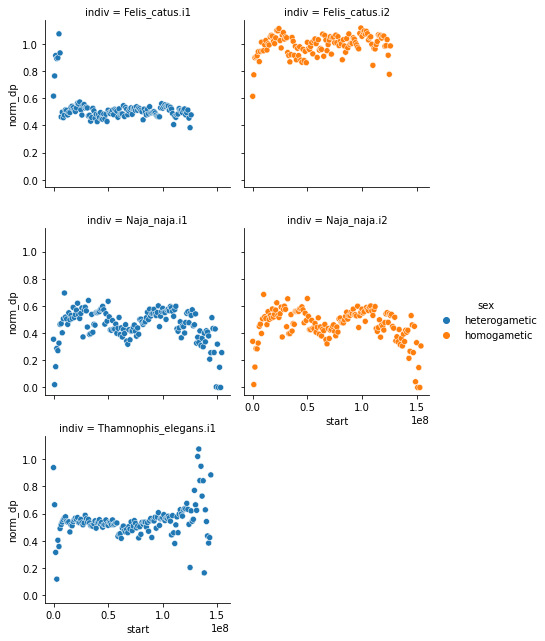

In [32]:
sns.relplot(data=depths_x, x="start", y="norm_dp", col="indiv", col_wrap=2, height=3, hue="sex")
#plt.savefig("pdfs/coverage_PAR_1Mb-mean.pdf")

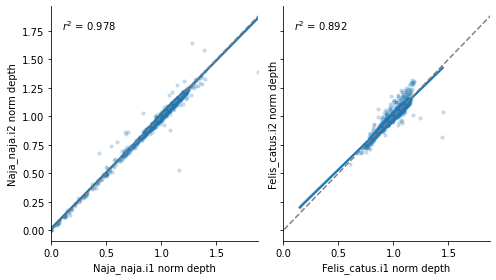

In [36]:
def plot_sexes_against(s1, s2, ax):
    i1 = depths[(depths.indiv==s1) & (depths.chrom=="A")].reset_index(drop=True)
    i2 = depths[(depths.indiv==s2) & (depths.chrom=="A")].reset_index(drop=True)
    bool_keep = [(r.norm_dp<2) & (i2.iloc[i].norm_dp<2) for i,r in i1.iterrows()]
    i1 = i1[bool_keep].reset_index(drop=True)
    i2 = i2[bool_keep].reset_index(drop=True)
    r, p = stats.pearsonr(i1.norm_dp,i2.norm_dp)
    r2 = r**2
    sns.regplot(x=i1.norm_dp, y=i2.norm_dp, scatter_kws={"alpha":0.2, "s":10}, ax=ax)
    ax.text(s=r"$r^2$ = {:.3f}".format(r2), x=0.05,y=0.9, transform=ax.transAxes)
    identity_line(color="gray",ax=ax)
    ax.set_xlabel("{} norm depth".format(s1))
    ax.set_ylabel("{} norm depth".format(s2))
    
f,ax = plt.subplots(1,2,figsize=[7,4],sharex=True, sharey=True)
plot_sexes_against("Naja_naja.i1","Naja_naja.i2", ax[0])
plot_sexes_against("Felis_catus.i1","Felis_catus.i2", ax[1])
plt.tight_layout()
sns.despine()
#plt.savefig("pdfs/Autosomal_coverage_between_sexes.pdf")

PAR in snakes

In [176]:
thamn_stats = pd.read_csv("../../sex_chromosome_coverage/Naja_naja.Z.seq_stats.txt.gz",sep="\t",compression="gzip", header=None)
thamn_stats.columns = ["chrom","start","end","gcu","atu","totalu","gc","at","total","rmsk_frac","n"]
thamn = depths_x[depths_x.indiv=='Thamnophis_elegans.i1'].reset_index(drop=True)
thamn_merged = thamn.set_index("start").join(thamn_stats.set_index("start"),lsuffix="left").reset_index()

thamn_phylo = pd.read_csv("../scripts/merged_features/Serpentes5.Thamnophis_elegans.features.txt.gz",sep="\t")
zphylo = thamn_phylo[thamn_phylo.chrom==sp2chrom["Thamnophis_elegans"][0]].reset_index(drop=True)
thamn_merged["excluded"] = [s<10e3 for s in zphylo["size"].values[:-1]]

In [180]:
subd = thamn_merged
x = np.array(subd.start + 500e3)
y = subd.norm_dp.values
frac = subd.rmsk_frac
lowess = sm.nonparametric.lowess(y,x, frac=0.2)

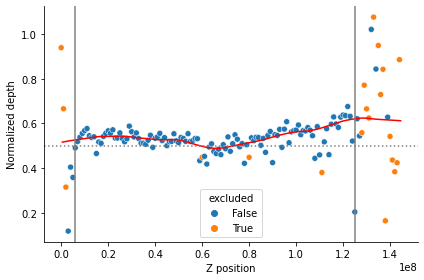

In [186]:
f,ax = plt.subplots()
#ax.scatter(x,y, s=10, alpha=0.8,color=rmsk_frac)
sns.scatterplot(data=subd, x="start",y="norm_dp",hue="excluded")
ax.plot([d[0] for d in lowess], [d[1] for d in lowess], color="red")
ax.axhline(y=0.5, linestyle="dotted",color="gray")
ax.axvline(x=6e6,color="gray")
ax.axvline(x=125e6,color="gray")
ax.set_xlabel("Z position")
ax.set_ylabel("Normalized depth")
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/Thamnophis_PAR_lowess_excludedBool.pdf")

Depth of coverage in Naja_naja

In [102]:
naja = pd.read_csv("../../sex_chromosome_coverage/Naja_naja.Z.seq_stats.txt.gz",sep="\t",compression="gzip", header=None)
naja.columns = ["chrom","start","end","gcu","atu","totalu","gc","at","total","rmsk_frac","n"]

In [103]:
najamerged = depths_x[depths_x.indiv=="Naja_naja.i1"].set_index("start").join(naja.set_index("start"),lsuffix="left")

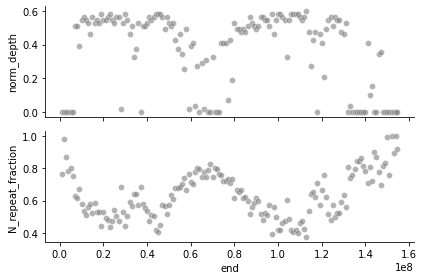

In [115]:
f,ax = plt.subplots(2,1, sharex=True)
sns.scatterplot(data=najamerged, x="end",y="norm_dp",ax=ax[0],color="gray",alpha=0.6)
sns.scatterplot(data=najamerged, x="end",y="rmsk_frac",ax=ax[1],color="gray",alpha=0.6)
ax[0].set_ylabel("norm_depth")
ax[1].set_ylabel("N_repeat_fraction")
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/Naja_Zseqstats_coverage.pdf")

<AxesSubplot:xlabel='start', ylabel='norm_dp'>

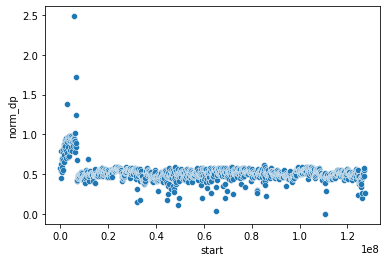

In [16]:
sns.scatterplot(data=depths_x[depths_x.indiv=="Frank_S17993"], x="start",y="norm_dp")

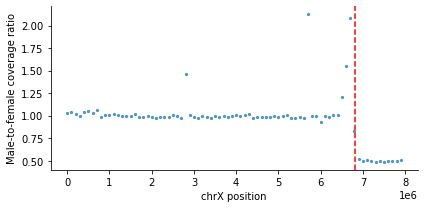

In [16]:
i1,i2 = 'Orion_S13227','Cali_S17799'
subd1 = depths_x[(depths_x.indiv==i1) & (depths_x.end <= 8e6)].sort_values(by="start").reset_index(drop=True)
subd2 = depths_x[(depths_x.indiv==i2) & (depths_x.end <= 8e6)].sort_values(by="start").reset_index(drop=True)

f,ax = plt.subplots(figsize=[6,3])
ax.scatter(x=subd1.start,y=subd1.norm_dp/subd2.norm_dp,alpha=0.7,s=5)
ax.axvline(x=6813699,color="red",linestyle="dashed")
ax.set_xlabel("chrX position")
ax.set_ylabel("Male-to-female coverage ratio")
sns.despine()
plt.tight_layout()
f.savefig("pdfs/cat_coverage_ratio_SHROOM2.pdf")

<AxesSubplot:xlabel='start', ylabel='norm_dp'>

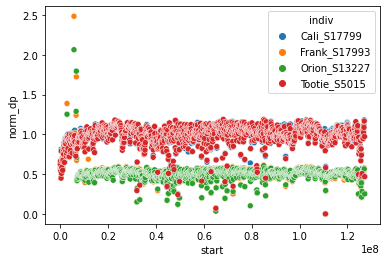

In [34]:
sns.scatterplot(data=depths[(depths.chrom=="chrX")], x="start",y="norm_dp", hue="indiv")